In [177]:
# Import Tensorflow for the bidirectional LSTM 
import tensorflow as tf
#from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt 
import numpy as np 

%matplotlib inline 
plt.style.use('ggplot')

# Readers for the conll format  
from nltk.corpus.reader import *
from nltk import flatten 

# Read the dataset 
train = ConllCorpusReader('../../Datasets/re3d-defense/CONLL-format/data/train/',
                          're3d-train.conll',
                          ['words', 'pos', 'chunk'])


test = ConllCorpusReader('../../Datasets/re3d-defense/CONLL-format/data/test/', 
                         're3d-test.conll',
                          ['words', 'pos', 'chunk'])



In [178]:
sentences = train.tagged_sents() + test.tagged_sents()
test_sentences = test.tagged_sents() 

print("Number of training records: " + str(len(sentences)))
print("Number of testing records: " + str(len(test.tagged_sents())))
print(sentences[1])

Number of training records: 965
Number of testing records: 200
[('The', 'B-Location'), ('hospital', 'I-Location'), ('has', 'O'), ('facilities', 'O'), ('for', 'O'), ('MRI', 'O'), ('and', 'O'), ('CT', 'O'), ('scan', 'O'), (',', 'O'), ('a', 'O'), ('gamma', 'O'), ('camera', 'O'), ('and', 'O'), ('lithotripsy', 'O'), ('device', 'O'), ('.', 'O')]


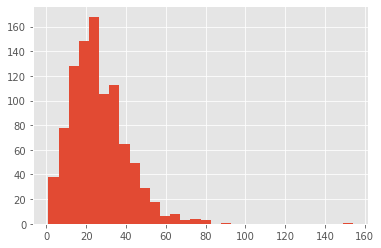

In [179]:
plt.hist([len(s) for s in sentences], bins=30)
plt.show()


In [180]:
# Max 
MAX_LENGTH = max([len(s) for s in sentences])
print("Max Length: " + str(MAX_LENGTH))

words = list(set(train.words() + test.words()))
words.append("ENDPAD")
N_WORDS = len(words) 

print("Number of words: " + str(N_WORDS))


tags = list(set(flatten([[tpl[1] for tpl in rec] for rec in sentences])))
N_TAGS = len(tags)

word_index = { w: i for i,w in enumerate(words) }
tag_index  = { t: i for i,t in enumerate(tags)  }

# from collections import Counter 
# o_count = Counter(flatten([[tpl[1] for tpl in rec] for rec in sentences])); 
# print(o_count)

X =[[word_index[word[0]] for word in sentence] for sentence in sentences]

X_TRAIN = pad_sequences(maxlen=MAX_LENGTH, 
                        sequences=X,
                        padding="post", value=N_WORDS-1)

Y =[[tag_index[word[1]] for word in sentence] for sentence in sentences]


Y_TRAIN = pad_sequences(maxlen=MAX_LENGTH, 
                        sequences=Y,
                        padding="post", value=tag_index['O'])

Y_TRAIN = [to_categorical(i, num_classes=N_TAGS) for i in Y_TRAIN]


from sklearn.model_selection import train_test_split
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_TRAIN,Y_TRAIN, test_size=0.2)

# X_TEST = [ [word_index[word[0]] for word in sentence] for sentence in test_sentences]

# X_TEST = pad_sequences(maxlen=MAX_LENGTH, 
#                         sequences=X_TEST,
#                         padding="post", value=N_WORDS-1)

# #Y_TEST =[[tag_index[word[1]] for word in sentence] for sentence in sentences]

# Y_TEST = pad_sequences(maxlen=MAX_LENGTH, 
#                         sequences=Y_TEST,
#                         padding="post", value=tag_index['O'])

# Y_TEST = [to_categorical(i, num_classes=N_TAGS) for i in Y_TEST]



Max Length: 154
Number of words: 4295


In [189]:
input = Input(shape=(MAX_LENGTH,))
model = Embedding(input_dim=N_WORDS, output_dim=N_TAGS, input_length=MAX_LENGTH)(input)
model = Dropout(0.1)(model) 
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out   = TimeDistributed(Dense(N_TAGS, activation='softmax'))(model)

model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model.fit(X_TRAIN, np.array(Y_TRAIN), batch_size=32, epochs=300, validation_split=0.2, verbose =1)


Train on 617 samples, validate on 155 samples
Epoch 1/300
617/617 [==============================] - 8s 13ms/sample - loss: 1.6427 - accuracy: 0.9149 - val_loss: 0.4130 - val_accuracy: 0.9473
Epoch 2/300
617/617 [==============================] - 4s 7ms/sample - loss: 0.3396 - accuracy: 0.9466 - val_loss: 0.3166 - val_accuracy: 0.9473
Epoch 3/300
617/617 [==============================] - 5s 8ms/sample - loss: 0.2877 - accuracy: 0.9466 - val_loss: 0.2994 - val_accuracy: 0.9473
Epoch 4/300
617/617 [==============================] - 4s 7ms/sample - loss: 0.2611 - accuracy: 0.9466 - val_loss: 0.2655 - val_accuracy: 0.9473
Epoch 5/300
617/617 [==============================] - 5s 9ms/sample - loss: 0.2391 - accuracy: 0.9466 - val_loss: 0.2519 - val_accuracy: 0.9473
Epoch 6/300
617/617 [==============================] - 5s 8ms/sample - loss: 0.2323 - accuracy: 0.9466 - val_loss: 0.2599 - val_accuracy: 0.9473
Epoch 7/300
617/617 [==============================] - 4s 7ms/sample - loss: 0.2269

Epoch 57/300
617/617 [==============================] - 6s 9ms/sample - loss: 0.0658 - accuracy: 0.9812 - val_loss: 0.1920 - val_accuracy: 0.9594
Epoch 58/300
617/617 [==============================] - 6s 9ms/sample - loss: 0.0636 - accuracy: 0.9815 - val_loss: 0.1953 - val_accuracy: 0.9592
Epoch 59/300
617/617 [==============================] - 4s 7ms/sample - loss: 0.0611 - accuracy: 0.9828 - val_loss: 0.1945 - val_accuracy: 0.9598
Epoch 60/300
617/617 [==============================] - 5s 8ms/sample - loss: 0.0626 - accuracy: 0.9819 - val_loss: 0.1921 - val_accuracy: 0.9605
Epoch 61/300
617/617 [==============================] - 6s 10ms/sample - loss: 0.0597 - accuracy: 0.9827 - val_loss: 0.1938 - val_accuracy: 0.9608
Epoch 62/300
617/617 [==============================] - 5s 8ms/sample - loss: 0.0564 - accuracy: 0.9835 - val_loss: 0.2009 - val_accuracy: 0.9605
Epoch 63/300
617/617 [==============================] - 6s 10ms/sample - loss: 0.0549 - accuracy: 0.9843 - val_loss: 0.2005

Epoch 113/300
617/617 [==============================] - 5s 8ms/sample - loss: 0.0173 - accuracy: 0.9951 - val_loss: 0.2405 - val_accuracy: 0.9620
Epoch 114/300
617/617 [==============================] - 6s 9ms/sample - loss: 0.0171 - accuracy: 0.9952 - val_loss: 0.2465 - val_accuracy: 0.9634
Epoch 115/300
617/617 [==============================] - 6s 10ms/sample - loss: 0.0169 - accuracy: 0.9951 - val_loss: 0.2408 - val_accuracy: 0.9635
Epoch 116/300
617/617 [==============================] - 6s 10ms/sample - loss: 0.0162 - accuracy: 0.9955 - val_loss: 0.2401 - val_accuracy: 0.9613
Epoch 117/300
617/617 [==============================] - 6s 9ms/sample - loss: 0.0157 - accuracy: 0.9955 - val_loss: 0.2411 - val_accuracy: 0.9623
Epoch 118/300
617/617 [==============================] - 6s 9ms/sample - loss: 0.0164 - accuracy: 0.9952 - val_loss: 0.2399 - val_accuracy: 0.9606
Epoch 119/300
617/617 [==============================] - 5s 8ms/sample - loss: 0.0160 - accuracy: 0.9953 - val_loss:

Epoch 169/300
617/617 [==============================] - 5s 8ms/sample - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.2665 - val_accuracy: 0.9630
Epoch 170/300
617/617 [==============================] - 5s 8ms/sample - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.2634 - val_accuracy: 0.9617
Epoch 171/300
617/617 [==============================] - 6s 10ms/sample - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.2623 - val_accuracy: 0.9615
Epoch 172/300
617/617 [==============================] - 6s 11ms/sample - loss: 0.0079 - accuracy: 0.9976 - val_loss: 0.2656 - val_accuracy: 0.9618
Epoch 173/300
617/617 [==============================] - 5s 9ms/sample - loss: 0.0077 - accuracy: 0.9977 - val_loss: 0.2663 - val_accuracy: 0.9602
Epoch 174/300
617/617 [==============================] - 5s 9ms/sample - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.2676 - val_accuracy: 0.9621
Epoch 175/300
617/617 [==============================] - 5s 8ms/sample - loss: 0.0072 - accuracy: 0.9980 - val_loss:

617/617 [==============================] - 6s 9ms/sample - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.2730 - val_accuracy: 0.9625
Epoch 225/300
617/617 [==============================] - 6s 10ms/sample - loss: 0.0052 - accuracy: 0.9983 - val_loss: 0.2787 - val_accuracy: 0.9621
Epoch 226/300
617/617 [==============================] - 6s 9ms/sample - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.2801 - val_accuracy: 0.9629
Epoch 227/300
617/617 [==============================] - 6s 10ms/sample - loss: 0.0047 - accuracy: 0.9983 - val_loss: 0.2774 - val_accuracy: 0.9616
Epoch 228/300
617/617 [==============================] - 6s 10ms/sample - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.2825 - val_accuracy: 0.9620
Epoch 229/300
617/617 [==============================] - 6s 9ms/sample - loss: 0.0050 - accuracy: 0.9983 - val_loss: 0.2851 - val_accuracy: 0.9634
Epoch 230/300
617/617 [==============================] - 7s 11ms/sample - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.2840 - va

Epoch 280/300
617/617 [==============================] - 7s 11ms/sample - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.2887 - val_accuracy: 0.9612
Epoch 281/300
617/617 [==============================] - 7s 12ms/sample - loss: 0.0035 - accuracy: 0.9988 - val_loss: 0.2858 - val_accuracy: 0.9634
Epoch 282/300
617/617 [==============================] - 5s 8ms/sample - loss: 0.0038 - accuracy: 0.9986 - val_loss: 0.2884 - val_accuracy: 0.9627
Epoch 283/300
617/617 [==============================] - 5s 7ms/sample - loss: 0.0038 - accuracy: 0.9986 - val_loss: 0.2854 - val_accuracy: 0.9628
Epoch 284/300
617/617 [==============================] - 4s 7ms/sample - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.2914 - val_accuracy: 0.9603
Epoch 285/300
617/617 [==============================] - 4s 7ms/sample - loss: 0.0042 - accuracy: 0.9983 - val_loss: 0.2864 - val_accuracy: 0.9621
Epoch 286/300
617/617 [==============================] - 5s 7ms/sample - loss: 0.0035 - accuracy: 0.9986 - val_loss:

In [198]:
i = 6
p = model.predict(np.array([X_TEST[i]]))
p = np.argmax(p, axis=-1)

print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_TEST[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))
    
#print(len(X_TRAIN[36]))
#print(words[X_TRAIN[4][1]])

model.save('inital.model')

Word           (True ): Pred
.             : O
Near          : O
Ayn           : B-Location
Isa           : I-Location
,             : O
three         : B-Quantity
strikes       : O
engaged       : O
two           : B-Quantity
ISIL          : B-Organisation
tactical      : I-Organisation
units         : I-Organisation
and           : O
destroyed     : O
a             : O
vehicle       : O
,             : O
five          : B-Person
fighting      : I-Location
positions     : I-Location
,             : O
a             : B-Location
command       : I-Location
and           : I-Location
control       : I-Location
node          : I-Location
,             : O
a             : B-Weapon
VBIED         : I-Weapon
,             : O
and           : O
a             : B-Weapon
heavy         : I-Weapon
machine       : I-Weapon
gun           : I-Weapon
.             : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD    

TypeError: unsupported callable